In [28]:
import sys
!{sys.executable} -m pip install uncertainties

Defaulting to user installation because normal site-packages is not writeable


In [29]:
import numpy as np
from mpl_toolkits import mplot3d
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["text.usetex"] = False
from matplotlib import cm, colors
from matplotlib.patches import Ellipse
import matplotlib as mpl
from numpy import arange,array,ones,linalg
from scipy.optimize import minimize
from scipy import stats

from astropy.io import fits
from astropy.table import Table, vstack
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import SphericalCircle
import math

from scipy.ndimage import gaussian_filter1d


# for classifier
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from joblib import dump, load
from uncertainties import ufloat

In [30]:
SGA = Table.read('SGA_Color_withGini.fits')
SGA

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,COLOR G-Z,COLOR G-R,COLOR R-Z,R50_R,m(r50)_G,m(r50)_Z,m(r50)_R,GRADIENT_G-Z,GRADIENT_G-R,GRADIENT_R-Z,C_INDEX_G_r50_r90,C_INDEX_R_r50_r90,C_INDEX_Z_r50_r90,r90_R,r50_G,r90_G,r50_Z,r90_Z,GINI_G,GINI_R,GINI_Z
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64
2,SGA-2020 2,PGC1283207,1283207,228.3770865,5.4232017,S?,152.2,0.36307806,0.724436,0.03463229,23.40448,16.976,False,LEDA-20181114,0,PGC1283207,1,True,228.3770865,5.4232017,0.36307806,2283p055,228.3770803831908,5.423191398593787,0.49470574,SB26,158.20142,0.545691,228.37700918822188,5.4232652570544015,10.897086,3.3509698,3.1147978,3.240862,5.902337,6.9126143,7.941369,8.997992,10.073601,11.199986,12.391357,13.561038,14.841172,16.966799,16.108246,15.486356,16.879545,16.024958,15.400715,16.818878,15.967034,15.341793,16.776297,15.925804,15.300776,16.746685,15.897334,15.272053,16.725166,15.876816,15.2521105,16.708357,15.862035,15.237181,16.696539,15.851936,15.226998,16.689613,15.844313,15.21976,0.013392451,0.02354,0.021872982,0.01736985,0.024445537,0.039866067,0.05026544,0.08455789,0.122911856,0.005682776,0.0054258136,0.0049038026,0.005588406,0.005323561,0.0047632363,0.00543534,0.005177031,0.0046343105,0.0053025587,0.005040888,0.0045181247,0.005206092,0.0049438984,0.0044374703,0.0051483097,0.0048758644,0.0043834248,0.0051032505,0.0048264163,0.004344248,0.0050705094,0.004792021,0.004319857,0.005054293,0.00476

## T-type classification

In [31]:
# Look at morph types in SGA
unique, counts = np.unique(SGA['MORPHTYPE'], return_counts = True)
print(unique, counts)

MORPHTYPE
---------
         
  .E+..?.
  .E+..P*
  .E+4...
  .E...P*
  .I..9P.
  .IBS9..
  .L..+P*
  .L?....
  .LXS-*.
      ...
      Sab
       Sb
      Sbc
       Sc
      Scd
       Sd
       Sm
     dIrr
dIrr/dSph
     dSph
    dSph?
Length = 65 rows [     3      1      3      1      1      1      2      1      1      1
      1      1      1      2      1      1      1      1      1      1
     35   1320      1   1117      1      5  45468   3251  11137     26
   2374    118    270      1 169164    419      2   4749  14527  39252
    330    771    804    141    129    957   1492   3463   3763   3473
    783    499    459   2887   5990  11076  17294  28455   3382   2470
   1712     15      6      5      1]


In [32]:
SGA.add_column(np.nan, name='T_TYPE')

# Elliptical and dwarf ellipticals
# 45468 
SGA['T_TYPE'][SGA['MORPHTYPE'] == 'E'] = -5

# Lenticulars
# 4749
SGA['T_TYPE'][SGA['MORPHTYPE'] == 'S0'] = -2
#14527
SGA['T_TYPE'][SGA['MORPHTYPE'] == 'S0-a'] = 0


# Spirals
# 2887 
SGA['T_TYPE'][SGA['MORPHTYPE'] == 'Sa'] = 1

# 5990
SGA['T_TYPE'][SGA['MORPHTYPE'] == 'Sab'] = 2

# 11076 
SGA['T_TYPE'][SGA['MORPHTYPE'] == 'Sb'] = 3

#17294 
SGA['T_TYPE'][SGA['MORPHTYPE'] == 'Sbc'] = 4

#28455 
SGA['T_TYPE'][SGA['MORPHTYPE'] == 'Sc'] = 5

#3382
SGA['T_TYPE'][SGA['MORPHTYPE'] == 'Scd'] = 6

#2470 
SGA['T_TYPE'][SGA['MORPHTYPE'] == 'Sd'] = 7

# Irregulars
SGA['T_TYPE'][SGA['MORPHTYPE'] == 'Sm'] = 9
SGA['T_TYPE'][SGA['MORPHTYPE'] == 'Irr'] = 10
SGA['T_TYPE'][SGA['MORPHTYPE'] == 'dIrr'] = 10
SGA['T_TYPE'][SGA['MORPHTYPE'] == 'I'] = 10

# Dwarf spheroidal (5)
SGA['T_TYPE'][SGA['MORPHTYPE'] == 'dSph'] = 11

In [33]:
SGA.sort('T_TYPE')
#Get color and morph parameters on new table for random forest 
Relevant = Table([SGA['MORPHTYPE'], SGA['T_TYPE'], SGA['GRADIENT_G-Z'], SGA['GRADIENT_G-R'], SGA['GRADIENT_R-Z'], 
                 SGA['C_INDEX_R_r50_r90'], SGA['COLOR G-Z'], SGA['COLOR G-R'], SGA['COLOR R-Z'], SGA['GINI_G'], SGA['GINI_R'], SGA['GINI_Z']])
Relevant

MORPHTYPE,T_TYPE,GRADIENT_G-Z,GRADIENT_G-R,GRADIENT_R-Z,C_INDEX_R_r50_r90,COLOR G-Z,COLOR G-R,COLOR R-Z,GINI_G,GINI_R,GINI_Z
bytes21,float64,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64
E,-5.0,-0.5369842,-0.07339646,-0.46358776,0.25481203,1.494731,0.9782467,0.51648426,0.7089031552639745,0.7220749473856489,0.768062908593354
E,-5.0,-0.53083605,-0.24365975,-0.2871763,0.20835827,1.6869307,1.0853043,0.6016264,0.6606828397718219,0.7005038312173211,0.7281851619187655
E,-5.0,-0.09060609,-0.04634577,-0.044260323,0.17891355,1.5189896,0.9096937,0.60929585,0.7139756957916816,0.7329502034752609,0.7281722459210835
E,-5.0,-0.105971575,-0.09282738,-0.013144195,0.14360416,1.7361784,1.0164785,0.71969986,0.7062869927954301,0.7252081943699109,0.8551951197953661
E,-5.0,-0.66179395,-0.25598752,-0.40580642,0.24141927,1.4583244,0.9870472,0.47127724,0.7064318081341784,0.7293388709825479,0.7755526498439915
E,-5.0,--,--,--,0.14834835,--,--,--,0.4676399443865718,0.4895451291153296,0.4952693186221861
E,-5.0,-0.42369863,-0.16379105,-0.2599076,0.2522917,1.7391319,1.0215645,0.71756744,0.7266267219365932,0.7483333668391309,0.7626366995012073
E,-5.0,-0.089765996,-0.04370889,-0.046057105,0.19391565,1.5149117,0.86676025,0.6481514,0.7521861716033815,0.7576239948809366,0.7621323401235267
E,-5.0,-0.108296275,0.006925285,-0.11522156,0.19418615,1.7074795,0.9784012,0.7290783,0.7923166096363903,0.7999565528978321,0.7985566154337043


In [34]:
# Group by ellipticals, spirals, lenticulars and irregulars (no barred galaxies)
Relevant.add_column('Undefined', name='TYPE')

spirals = [1, 2, 3, 4, 5, 6, 7]
for i in spirals:
    Relevant['TYPE'][Relevant['T_TYPE'] == i] = 'Spirals'

Relevant['TYPE'][Relevant['T_TYPE'] == -5] = 'Elliptic'

Relevant['TYPE'][Relevant['T_TYPE'] == -2] = 'Len'
Relevant['TYPE'][Relevant['T_TYPE'] == 0] = 'Len'

#Relevant['TYPE'][Relevant['T_TYPE'] == 9] = 'Irregular'
Relevant['TYPE'][Relevant['T_TYPE'] == 10] = 'Irregular'
Relevant

MORPHTYPE,T_TYPE,GRADIENT_G-Z,GRADIENT_G-R,GRADIENT_R-Z,C_INDEX_R_r50_r90,COLOR G-Z,COLOR G-R,COLOR R-Z,GINI_G,GINI_R,GINI_Z,TYPE
bytes21,float64,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,str9
E,-5.0,-0.5369842,-0.07339646,-0.46358776,0.25481203,1.494731,0.9782467,0.51648426,0.7089031552639745,0.7220749473856489,0.768062908593354,Elliptic
E,-5.0,-0.53083605,-0.24365975,-0.2871763,0.20835827,1.6869307,1.0853043,0.6016264,0.6606828397718219,0.7005038312173211,0.7281851619187655,Elliptic
E,-5.0,-0.09060609,-0.04634577,-0.044260323,0.17891355,1.5189896,0.9096937,0.60929585,0.7139756957916816,0.7329502034752609,0.7281722459210835,Elliptic
E,-5.0,-0.105971575,-0.09282738,-0.013144195,0.14360416,1.7361784,1.0164785,0.71969986,0.7062869927954301,0.7252081943699109,0.8551951197953661,Elliptic
E,-5.0,-0.66179395,-0.25598752,-0.40580642,0.24141927,1.4583244,0.9870472,0.47127724,0.7064318081341784,0.7293388709825479,0.7755526498439915,Elliptic
E,-5.0,--,--,--,0.14834835,--,--,--,0.4676399443865718,0.4895451291153296,0.4952693186221861,Elliptic
E,-5.0,-0.42369863,-0.16379105,-0.2599076,0.2522917,1.7391319,1.0215645,0.71756744,0.7266267219365932,0.7483333668391309,0.7626366995012073,Elliptic
E,-5.0,-0.089765996,-0.04370889,-0.046057105,0.19391565,1.5149117,0.86676025,0.6481514,0.7521861716033815,0.7576239948809366,0.7621323401235267,Elliptic
E,-5.0,-0.108296275,0.006925285,-0.11522156,0.19418615,1.7074795,0.9784012,0.7290783,0.7923166096363903,0.7999565528978321,0.7985566154337043,Elliptic


In [35]:
Relevant[Relevant['TYPE'] == 'Undefined']

MORPHTYPE,T_TYPE,GRADIENT_G-Z,GRADIENT_G-R,GRADIENT_R-Z,C_INDEX_R_r50_r90,COLOR G-Z,COLOR G-R,COLOR R-Z,GINI_G,GINI_R,GINI_Z,TYPE
bytes21,float64,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,str9
Sm,9.0,0.13640028,0.08762047,0.048779815,0.38616866,0.60614777,0.39414024,0.21200752,0.5891048631405937,0.5572520405004323,0.515692315904421,Undefined
Sm,9.0,-0.449233,-0.19035956,-0.2588734,0.46027014,1.650197,0.9114666,0.73873043,0.6744052496056647,0.7101906789423539,0.7260019559891784,Undefined
Sm,9.0,0.1740165,-0.043727018,0.21774352,0.3629024,0.56702614,0.35326576,0.21376038,0.7123817753150768,0.7120805356540812,0.6691930288476261,Undefined
Sm,9.0,-1.797117,-0.030591369,-1.7665257,0.36293313,0.017069817,0.52635384,-0.509284,0.553821107148727,0.5558182858487225,0.6095018196272438,Undefined
Sm,9.0,-0.09330261,-0.059972107,-0.0333305,0.22553946,0.63246346,0.37584305,0.2566204,0.6518865253568588,0.6706813169305504,0.6542351378131911,Undefined
Sm,9.0,-0.45281002,-0.19200471,-0.2608053,0.4796629,0.99346447,0.5483074,0.44515705,0.6655295412296739,0.7102114540177874,0.7224027546421412,Undefined
Sm,9.0,-0.03318411,0.040005207,-0.07318932,0.35463876,1.0146904,0.65372086,0.36096954,--,--,--,Undefined
Sm,9.0,0.03064166,-0.0003348291,0.03097649,0.25801355,1.6983585,0.9874401,0.7109184,0.7455047907150721,0.7641607221009717,0.7646186944583102,Undefined
Sm,9.0,-0.85645294,-0.25972873,-0.59672415,0.53215104,1.5123043,0.8940582,0.6182461,--,--,--,Undefined


In [36]:
Relevant[Relevant['TYPE'] == 'Undefined']
n = len(Relevant[Relevant['TYPE'] == 'Undefined'])

In [37]:
#Remove all rows with undefined morph type
Relevant.sort('TYPE')
Relevant.remove_rows([range((len(Relevant) - n),len(Relevant))])
Relevant

/global/common/software/desi/perlmutter/desiconda/20230111-2.1.0/conda/lib/python3.10/site-packages/astropy/table/table.py:2750: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  keep_mask[row_specifier] = False


MORPHTYPE,T_TYPE,GRADIENT_G-Z,GRADIENT_G-R,GRADIENT_R-Z,C_INDEX_R_r50_r90,COLOR G-Z,COLOR G-R,COLOR R-Z,GINI_G,GINI_R,GINI_Z,TYPE
bytes21,float64,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,str9
E,-5.0,-0.5369842,-0.07339646,-0.46358776,0.25481203,1.494731,0.9782467,0.51648426,0.7089031552639745,0.7220749473856489,0.768062908593354,Elliptic
E,-5.0,-0.065739065,0.009576708,-0.07531577,0.26372635,1.4767199,0.83605576,0.6406641,0.7157851481129739,0.7319610826183206,0.7056223200583196,Elliptic
E,-5.0,-0.7994015,-0.08701193,-0.7123896,0.07881972,1.8686428,1.2358875,0.6327553,0.6431034192497164,0.6706981295687374,0.74193224509162,Elliptic
E,-5.0,-0.21077347,-0.14470908,-0.06606439,0.24908261,1.5546103,0.90292835,0.6516819,0.7366244769669638,0.7550234441902871,0.766530397253896,Elliptic
E,-5.0,-0.48766157,-0.12424697,-0.3634146,0.26483056,1.531208,0.9509735,0.5802345,0.7919229773277829,0.8064153025155713,0.820757734303387,Elliptic
E,-5.0,-0.3401958,-0.10322696,-0.23696885,0.19278267,1.6049633,1.0054064,0.5995569,0.7504674289273621,0.7600661682150734,0.7970225414866451,Elliptic
E,-5.0,--,--,--,--,--,--,--,0.6419232870907602,0.6441716629634248,0.7627260031650012,Elliptic
E,-5.0,-0.49376047,-0.049375325,-0.44438517,0.24904494,1.3504372,0.8696413,0.48079586,0.8011237485594123,0.8137575667685386,0.8417360250807098,Elliptic
E,-5.0,-0.119081974,-0.048656464,-0.07042551,0.07480733,1.6174545,0.94095516,0.67649937,0.6727668854714033,0.6971990942255121,0.6797460933908485,Elliptic


In [38]:
filtering_for_classifier = np.logical_not(Relevant['GRADIENT_G-Z'].mask)& np.logical_not(Relevant['GRADIENT_G-R'].mask)& np.logical_not(Relevant['GRADIENT_R-Z'].mask) & np.logical_not(Relevant['C_INDEX_R_r50_r90'].mask)& np.logical_not(Relevant['COLOR G-Z'].mask) & np.logical_not(Relevant['COLOR G-R'].mask)& np.logical_not(Relevant['COLOR R-Z'].mask)& np.logical_not(Relevant['GINI_R'].mask)& np.logical_not(Relevant['GINI_G'].mask)& np.logical_not(Relevant['GINI_Z'].mask)
Data = Relevant[filtering_for_classifier]
Data

MORPHTYPE,T_TYPE,GRADIENT_G-Z,GRADIENT_G-R,GRADIENT_R-Z,C_INDEX_R_r50_r90,COLOR G-Z,COLOR G-R,COLOR R-Z,GINI_G,GINI_R,GINI_Z,TYPE
bytes21,float64,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,str9
E,-5.0,-0.5369842,-0.07339646,-0.46358776,0.25481203,1.494731,0.9782467,0.51648426,0.7089031552639745,0.7220749473856489,0.768062908593354,Elliptic
E,-5.0,-0.065739065,0.009576708,-0.07531577,0.26372635,1.4767199,0.83605576,0.6406641,0.7157851481129739,0.7319610826183206,0.7056223200583196,Elliptic
E,-5.0,-0.7994015,-0.08701193,-0.7123896,0.07881972,1.8686428,1.2358875,0.6327553,0.6431034192497164,0.6706981295687374,0.74193224509162,Elliptic
E,-5.0,-0.21077347,-0.14470908,-0.06606439,0.24908261,1.5546103,0.90292835,0.6516819,0.7366244769669638,0.7550234441902871,0.766530397253896,Elliptic
E,-5.0,-0.48766157,-0.12424697,-0.3634146,0.26483056,1.531208,0.9509735,0.5802345,0.7919229773277829,0.8064153025155713,0.820757734303387,Elliptic
E,-5.0,-0.3401958,-0.10322696,-0.23696885,0.19278267,1.6049633,1.0054064,0.5995569,0.7504674289273621,0.7600661682150734,0.7970225414866451,Elliptic
E,-5.0,-0.49376047,-0.049375325,-0.44438517,0.24904494,1.3504372,0.8696413,0.48079586,0.8011237485594123,0.8137575667685386,0.8417360250807098,Elliptic
E,-5.0,-0.119081974,-0.048656464,-0.07042551,0.07480733,1.6174545,0.94095516,0.67649937,0.6727668854714033,0.6971990942255121,0.6797460933908485,Elliptic
E,-5.0,-0.10071872,-0.08763887,-0.013079852,0.23602146,1.5228395,0.8931446,0.62969494,0.6932573719148509,0.7121325460556305,0.7113957789334985,Elliptic


In [39]:
unique, counts = np.unique(Data['MORPHTYPE'], return_counts = True)
print(unique, counts)

MORPHTYPE
---------
        E
        I
       S0
     S0-a
       Sa
      Sab
       Sb
      Sbc
       Sc
      Scd
       Sd
     dIrr [40831  2035  4227 13314  2594  5452 10122 15921 26495  3116  2276     8]


In [40]:
unique, counts = np.unique(Data['TYPE'], return_counts = True)
print(unique, counts)

   TYPE  
---------
 Elliptic
Irregular
      Len
  Spirals [40831  2043 17541 65976]


In [41]:
# Get equal samples for all general types of galaxies, in this case take min. value of 3975 for each
sample_elliptical = Data[Data['TYPE'] == 'Elliptic'][:2043]
sample_lenticular = Data[Data['TYPE'] == 'Len'][:2043]
sample_spirals = Data[Data['TYPE'] == 'Spirals'][:2043]
sample_irregular = Data[Data['TYPE'] == 'Irregular']
new_data = vstack([sample_elliptical, sample_lenticular, sample_spirals, sample_irregular])
new_data

MORPHTYPE,T_TYPE,GRADIENT_G-Z,GRADIENT_G-R,GRADIENT_R-Z,C_INDEX_R_r50_r90,COLOR G-Z,COLOR G-R,COLOR R-Z,GINI_G,GINI_R,GINI_Z,TYPE
bytes21,float64,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,str9
E,-5.0,-0.5369842,-0.07339646,-0.46358776,0.25481203,1.494731,0.9782467,0.51648426,0.7089031552639745,0.7220749473856489,0.768062908593354,Elliptic
E,-5.0,-0.065739065,0.009576708,-0.07531577,0.26372635,1.4767199,0.83605576,0.6406641,0.7157851481129739,0.7319610826183206,0.7056223200583196,Elliptic
E,-5.0,-0.7994015,-0.08701193,-0.7123896,0.07881972,1.8686428,1.2358875,0.6327553,0.6431034192497164,0.6706981295687374,0.74193224509162,Elliptic
E,-5.0,-0.21077347,-0.14470908,-0.06606439,0.24908261,1.5546103,0.90292835,0.6516819,0.7366244769669638,0.7550234441902871,0.766530397253896,Elliptic
E,-5.0,-0.48766157,-0.12424697,-0.3634146,0.26483056,1.531208,0.9509735,0.5802345,0.7919229773277829,0.8064153025155713,0.820757734303387,Elliptic
E,-5.0,-0.3401958,-0.10322696,-0.23696885,0.19278267,1.6049633,1.0054064,0.5995569,0.7504674289273621,0.7600661682150734,0.7970225414866451,Elliptic
E,-5.0,-0.49376047,-0.049375325,-0.44438517,0.24904494,1.3504372,0.8696413,0.48079586,0.8011237485594123,0.8137575667685386,0.8417360250807098,Elliptic
E,-5.0,-0.119081974,-0.048656464,-0.07042551,0.07480733,1.6174545,0.94095516,0.67649937,0.6727668854714033,0.6971990942255121,0.6797460933908485,Elliptic
E,-5.0,-0.10071872,-0.08763887,-0.013079852,0.23602146,1.5228395,0.8931446,0.62969494,0.6932573719148509,0.7121325460556305,0.7113957789334985,Elliptic


In [42]:
unique, counts = np.unique(new_data['TYPE'], return_counts = True)
print(unique, counts)

   TYPE  
---------
 Elliptic
Irregular
      Len
  Spirals [2043 2043 2043 2043]


## Random forest (with barred galaxies as their respective spiral categories)

In [43]:
# Determine the correct shapes of the array
N = len(new_data)
X = np.zeros((N,10)) 

# Basically copying columns to associate later
X[:,0]= new_data['GRADIENT_G-Z']
X[:,1]= new_data['GRADIENT_G-R']
X[:,2]= new_data['GRADIENT_R-Z']
X[:,3]= new_data['C_INDEX_R_r50_r90']
X[:,4]= new_data['COLOR G-Z']
X[:,5]= new_data['COLOR G-R']
X[:,6]= new_data['COLOR R-Z']
X[:,7]= new_data['GINI_G']
X[:,8]= new_data['GINI_R']
X[:,9]= new_data['GINI_Z']

# Target data array
y = np.array(new_data['TYPE'])
print(X.size, y.size)

81720 8172


In [44]:
# Train and test data samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

X_train.shape, X_test.shape

((4903, 10), (3269, 10))

In [45]:
y_train.shape, y_test.shape

((4903,), (3269,))

In [46]:
# create random forest
random_forest_100 = RandomForestClassifier(n_estimators=100, random_state=42)

# fit the model to the training set
classification_fit = random_forest_100.fit(X_train, y_train)

# Predict on the test set results
y_pred = random_forest_100.predict(X_test)

# Check accuracy score 
print('Model accuracy score with 100 decision trees : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
accuracy = accuracy_score(y_test, y_pred,normalize=False)
print('Correctly classified points =', accuracy)

Model accuracy score with 100 decision trees : 0.7057
Correctly classified points = 2307


In [47]:
# Evaluate the classifier
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

    Elliptic       0.70      0.58      0.64       838
   Irregular       0.82      0.79      0.80       808
         Len       0.58      0.67      0.62       789
     Spirals       0.74      0.78      0.76       834

    accuracy                           0.71      3269
   macro avg       0.71      0.71      0.71      3269
weighted avg       0.71      0.71      0.71      3269



In [48]:
feature_scores = random_forest_100.feature_importances_
feature_scores

array([0.06962739, 0.09425899, 0.06754997, 0.14142164, 0.14818933,
       0.16298945, 0.10159052, 0.05898135, 0.06771818, 0.08767319])

In [50]:
feature_scores = random_forest_100.feature_importances_

array = np.array([['Gradient_G-Z', feature_scores[0]], ['Gradient_G-R',  feature_scores[1]], 
                  ['Gradient_R_Z', feature_scores[2]], ['C_INDEX_R_r50_r90', feature_scores[3]],  
                  ['COLOR G-Z', feature_scores[4]], ['COLOR G-R', feature_scores[5]], ['COLOR R-Z', feature_scores[6]],
                ['GINI_G', feature_scores[7]], ['GINI_R', feature_scores[8]], ['GINI_Z', feature_scores[9]]]) 

column_values = ['Parameters', 'Feature_Scores'] 

index_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] 

Feature_scores = pd.DataFrame(data = array,  
                  index = index_values,  
                  columns = column_values) 

# displaying the dataframe 
Feature_scores.sort_values(by=['Feature_Scores'], ascending=False)

,Parameters,Feature_Scores
6,COLOR G-R,0.1629894460089579
5,COLOR G-Z,0.14818933208135063
4,C_INDEX_R_r50_r90,0.14142163531062524
7,COLOR R-Z,0.10159052264757666
2,Gradient_G-R,0.0942589933735854
10,GINI_Z,0.08767318848067722
1,Gradient_G-Z,0.06962738574913264
9,GINI_R,0.06771817582475774
3,Gradient_R_Z,0.06754997230489376
8,GINI_G,0.058981348218442836


## Confusion matrix

In [51]:
cm = confusion_matrix(y_test, y_pred)

print('Confusion matrix\n\n', cm)

Confusion matrix

 [[489  44 258  47]
 [  8 635  49 116]
 [185  11 530  63]
 [ 15  84  82 653]]


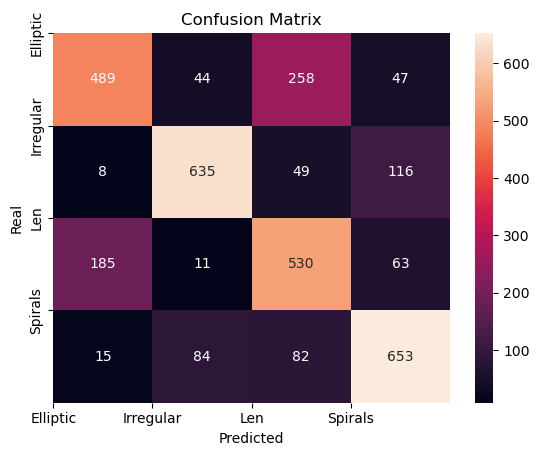

In [52]:
# Visualizing confusion matrix
sns.heatmap(cm, annot=True, fmt="d")

plt.xlabel('Predicted')
plt.ylabel('Real')
plt.title('Confusion Matrix')
plt.xticks(np.arange(len(np.unique(y))), np.unique(y))
plt.yticks(np.arange(len(np.unique(y))), np.unique(y))

plt.show()

In [53]:
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
poisson = np.sqrt(cm.astype('float')) / cm.sum(axis=1)[:, np.newaxis]
cm

array([[0.58353222, 0.05250597, 0.30787589, 0.05608592],
       [0.00990099, 0.78589109, 0.06064356, 0.14356436],
       [0.23447402, 0.0139417 , 0.67173638, 0.07984791],
       [0.01798561, 0.10071942, 0.09832134, 0.78297362]])

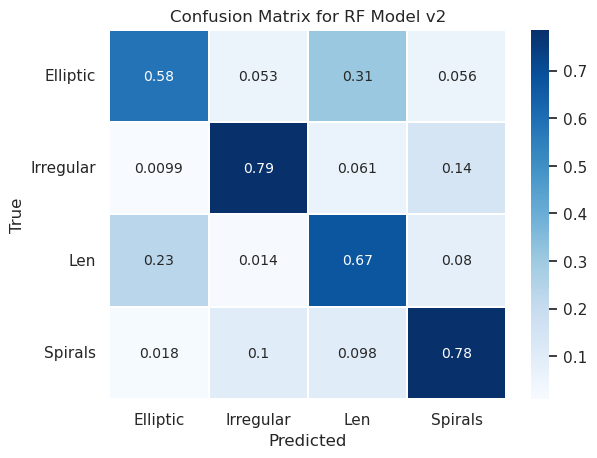

In [55]:
# Get and reshape confusion matrix data
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#poisson = np.sqrt(cm.astype('float')) / cm.sum(axis=1)[:, np.newaxis]

# Build the plot
sns.set(font_scale=1.0)
sns.heatmap(cm, annot=True, annot_kws={'size':10}, linewidths=0.2, cmap = 'Blues')

# Add labels to the plot
class_names = ['Elliptic', 'Irregular', 'Len', 'Spirals']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks + 0.5, class_names, rotation=0)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for RF Model v2')
plt.show()